# Scratch Detection


## Introduction:

In the semiconductor industry, **"wafers"** are thin discs of semiconductor material, such as silicon, used to fabricate microelectronic devices such as transistors, integrated circuits, and other components. A single wafer can contain hundreds or thousands of individual devices, known as **"dies"**, which are typically cut or "diced" from the wafer after the manufacturing process is completed.



One of the challenges in manufacturing wafers is to identify and isolate defects, including scratches, which can affect the performance and reliability of the resulting devices.

Scratches are seen as elongated clusters of bad dies that have a high aspect ratio, meaning they are relatively thin and long compared to their width. They can be caused by equipment misalignment or mishandling by humans, and may contain latent defects that can affect the performance of the devices. Scratches may not always be continuous, so sometimes there may be good dies within the scratch. These good dies are often marked for removal in a manual process called "**Inked dies**"



In the data that you receive, there may be faulty dies that are part of a scratch, which are labeled as "Scratch" as well as a few good dies that are part of a scratch, which are labeled as "Ink."

Many times, the Scratch Detection process will be done on the logical wafer map and not on a visual image of it.

The data that you received is called **"wafer map"** as it maps the status of all dies in the wafer.

The dies in the wafers are tested in a large number of stations, operations, and in each operation it is possible to create a map of the dies in this operation by coloring the good dies in a certain color and the faulty dies in another color.



Note, that this scratch is not continuous, meaning, not all the dies which are placed on this scratch are considered faults in this operation. We have to identify all scracthed dies including bad & good. The good dies that are part of the scartch have to be itendified actively in order to be killed. This process is called "inking".

We kill them because we fear that a physical scratch on the silicon wafer is what caused the sequence of these faulty dies, therefore even dies that passed the tests may be of low quality because they were damaged by the scratch on which they are placed.



You can read more about the causes of die failures here: <a href="https://semiengineering.com/why-chips-die//">Why Chips Die</a>

## Assignment description

In this assignment you are receiving wafer maps in a certain operation and the goal is to predict whether a given die belongs to scratch or not.

The data includes information about individual dies from a number of wafers.

The table data includes the following columns:

-  `WaferName` : The name of the wafer from which the die came.
- `DieX`: The horizontal position of the die on the wafer.
- `DieY`: The vertical position of the die on the wafer.
- `IsGoodDie`: A binary column indicating whether the die is good or not.
- `IsScratchDie`: A binary column indicating whether the die belongs to a scratch or not.

Your goal is to use the training data to build a model that can predict, given a certain wafer map, the dies on the map that are parts of a scratch (whether they are bad, 'Scratch' or good, 'Ink').

*The purpose of the assignment is mainly to get to reasonable solution that can help the business. Please note that real industry solutions usually achieve lower scores than you may be used from academic problems so even a low metric score on the test set may be considered a success*

Business goals:

- **Automation**. This process is currently a manual and expensive procedure that takes a lot of time and is prone to errors by the tagger. The goal is to perform this procedure in a faster time and save the costs of the test
- **Quality**. increasing the quality of the dies while balancing quality and yield (on the one hand, not to miss scratches, on the other hand not to do too much "Ink")
- **Prediction Level**. As explained above, the main goal is to detect individual dies, but sometimes it will help to also get a classification at the wafer level, (binary classification, is there a scratch on this wafer or not?) because there are manufacturers who return scratched wafers to the factory.

**Note**. In wafers with a low yield (that is, a lot of faulty dies), we will **not** perform scratch detection because the customer is afraid to find randomly generated scratches there and perform unnecessary ink. In such cases, the customer will make sure to check all the dies strictly in any case, but regardless of the detection of scratches. Therefore, in these cases we will not consider a sequence of bad die to be scratch.



# Start work

In [ ]:
import pandas as pd
import zipfile
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE

### Load Data

In [ ]:
#load zip file
zf = zipfile.ZipFile('data.zip')

In [ ]:
#load train data
df_wafers = pd.read_csv(zf.open('wafers_train.csv'))
df_wafers.head()

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,8PFrAN,0,27,True,False
1,8PFrAN,0,28,True,False
2,8PFrAN,0,29,True,False
3,8PFrAN,0,30,True,False
4,8PFrAN,0,31,True,False


In [ ]:
#load test data
df_wafers_test = pd.read_csv(zf.open('wafers_test.csv'))
df_wafers_test.head()

,WaferName,DieX,DieY,IsGoodDie
0,mZa9ls,0,23,True
1,mZa9ls,0,24,True
2,mZa9ls,0,25,True
3,mZa9ls,0,26,True
4,mZa9ls,0,27,True


You can draw the wafers map to see how the wafers look like in the data.

Using the following helper function you can draw the wafer maps with or without labels:

In [ ]:
def plot_wafer_maps(wafer_df_list, figsize, labels = True):
    """
    plot wafer maps for list of df of wafers

    :param wafer_df_list: list, The list of df's of the wafers
    :param figsize: int, the size of the figsize height
    :param labels: bool, Whether to show the layer of labels (based on column 'IsScratchDie')

    :return: None
    """
    def plot_wafer_map(wafer_df, ax, map_type):
        wafer_size = len(wafer_df)
        s = 2**17/(wafer_size)
        if map_type == 'Label':
            mes = 'Scratch Wafer' if (wafer_df['IsScratchDie'] == True).sum()>0 else 'Non-Scratch Wafer'
        else:
            mes = 'Yield: ' + str(round((wafer_df['IsGoodDie']).sum()/(wafer_df['IsGoodDie']).count(), 2))

        ax.set_title(f'{map_type} | Wafer Name: {wafer_df["WaferName"].iloc[0]}, \nSum: {len(wafer_df)} dies. {mes}', fontsize=20)
        ax.scatter(wafer_df['DieX'], wafer_df['DieY'], color = 'green', marker='s', s = s)

        bad_bins = wafer_df.loc[wafer_df['IsGoodDie'] == False]
        ax.scatter(bad_bins['DieX'], bad_bins['DieY'], color = 'red', marker='s', s = s)

        if map_type == 'Label':
            scratch_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == False)]
            ax.scatter(scratch_bins['DieX'], scratch_bins['DieY'], color = 'blue', marker='s', s = s)

            ink_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == True)]
            ax.scatter(ink_bins['DieX'], ink_bins['DieY'], color = 'yellow', marker='s', s = s)

            ax.legend(['Good Die', 'Bad Die', 'Scratch Die', 'Ink Die'], fontsize=8)
        else:
            ax.legend(['Good Die', 'Bad Die'], fontsize=8)

        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    import numpy as np
    import matplotlib.pyplot as plt

    if labels:
        fig, ax = plt.subplots(2, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize*2))
        for idx1, wafer_df in enumerate(wafer_df_list):
            for idx2, map_type in enumerate(['Input', 'Label']):
                plot_wafer_map(wafer_df, ax[idx2][idx1], map_type)
    else:
        fig, ax = plt.subplots(1, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize))
        for idx, wafer_df in enumerate(wafer_df_list):
            plot_wafer_map(wafer_df, ax[idx], 'Input')

    plt.show()

Select the amount of samples you want to display:

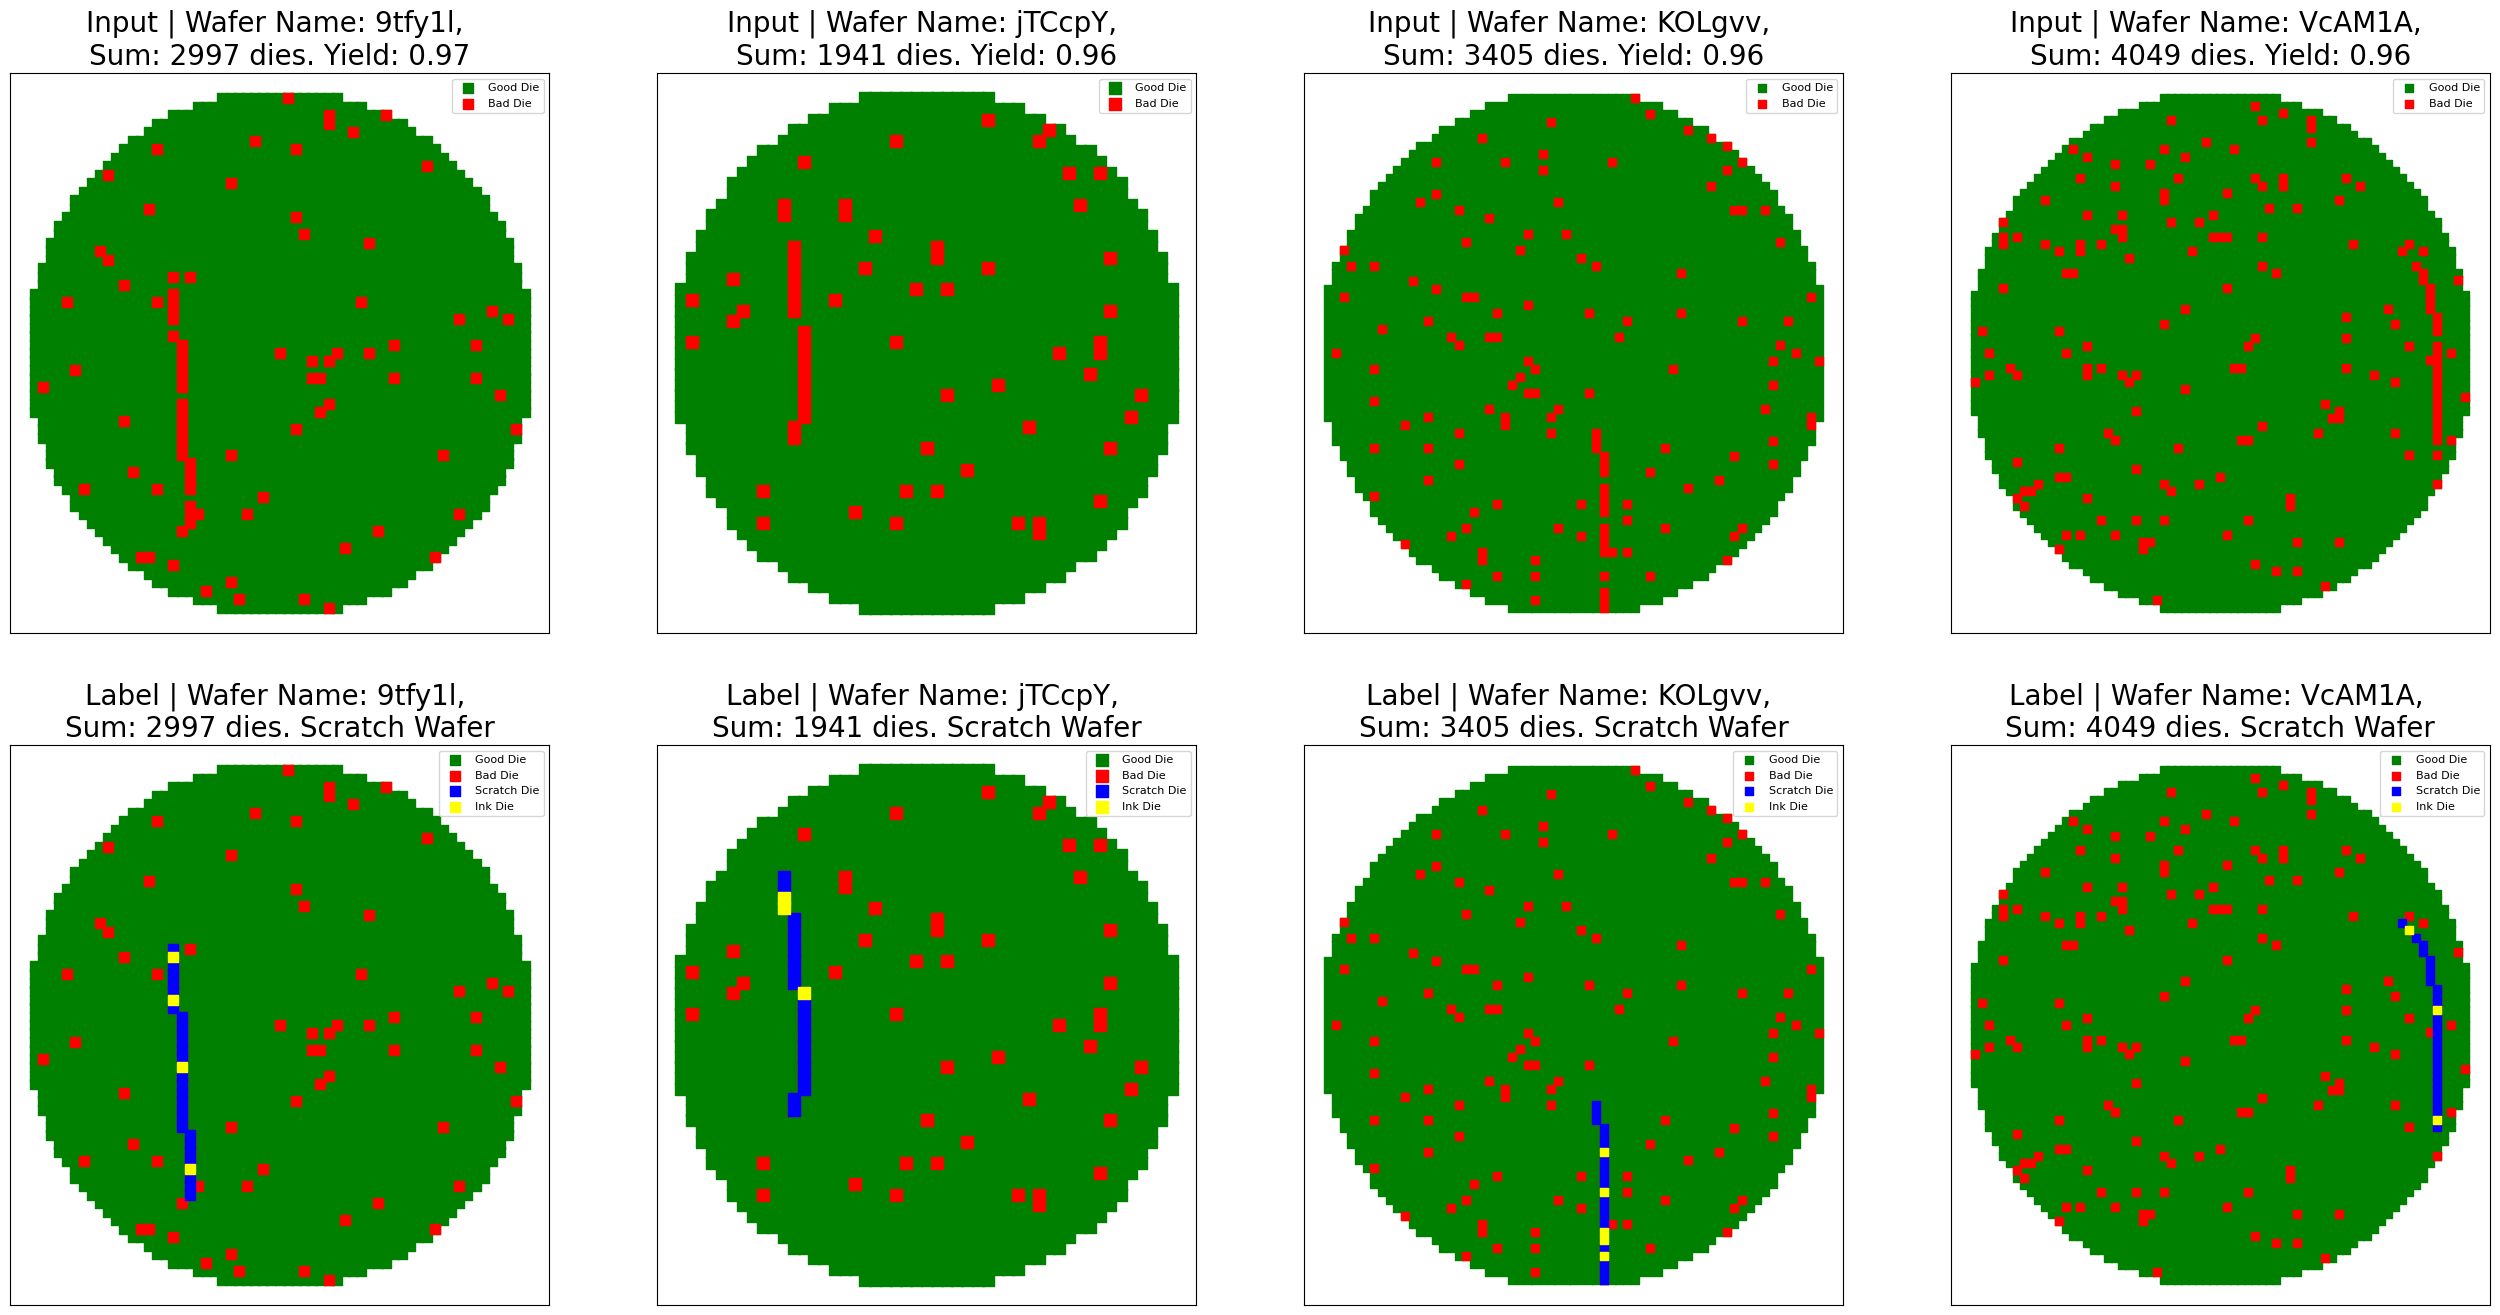

In [ ]:
n_samples = 4
list_sample_train = [df_wafers.groupby('WaferName').get_group(group) for group in df_wafers['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_train, figsize = 8, labels = True)

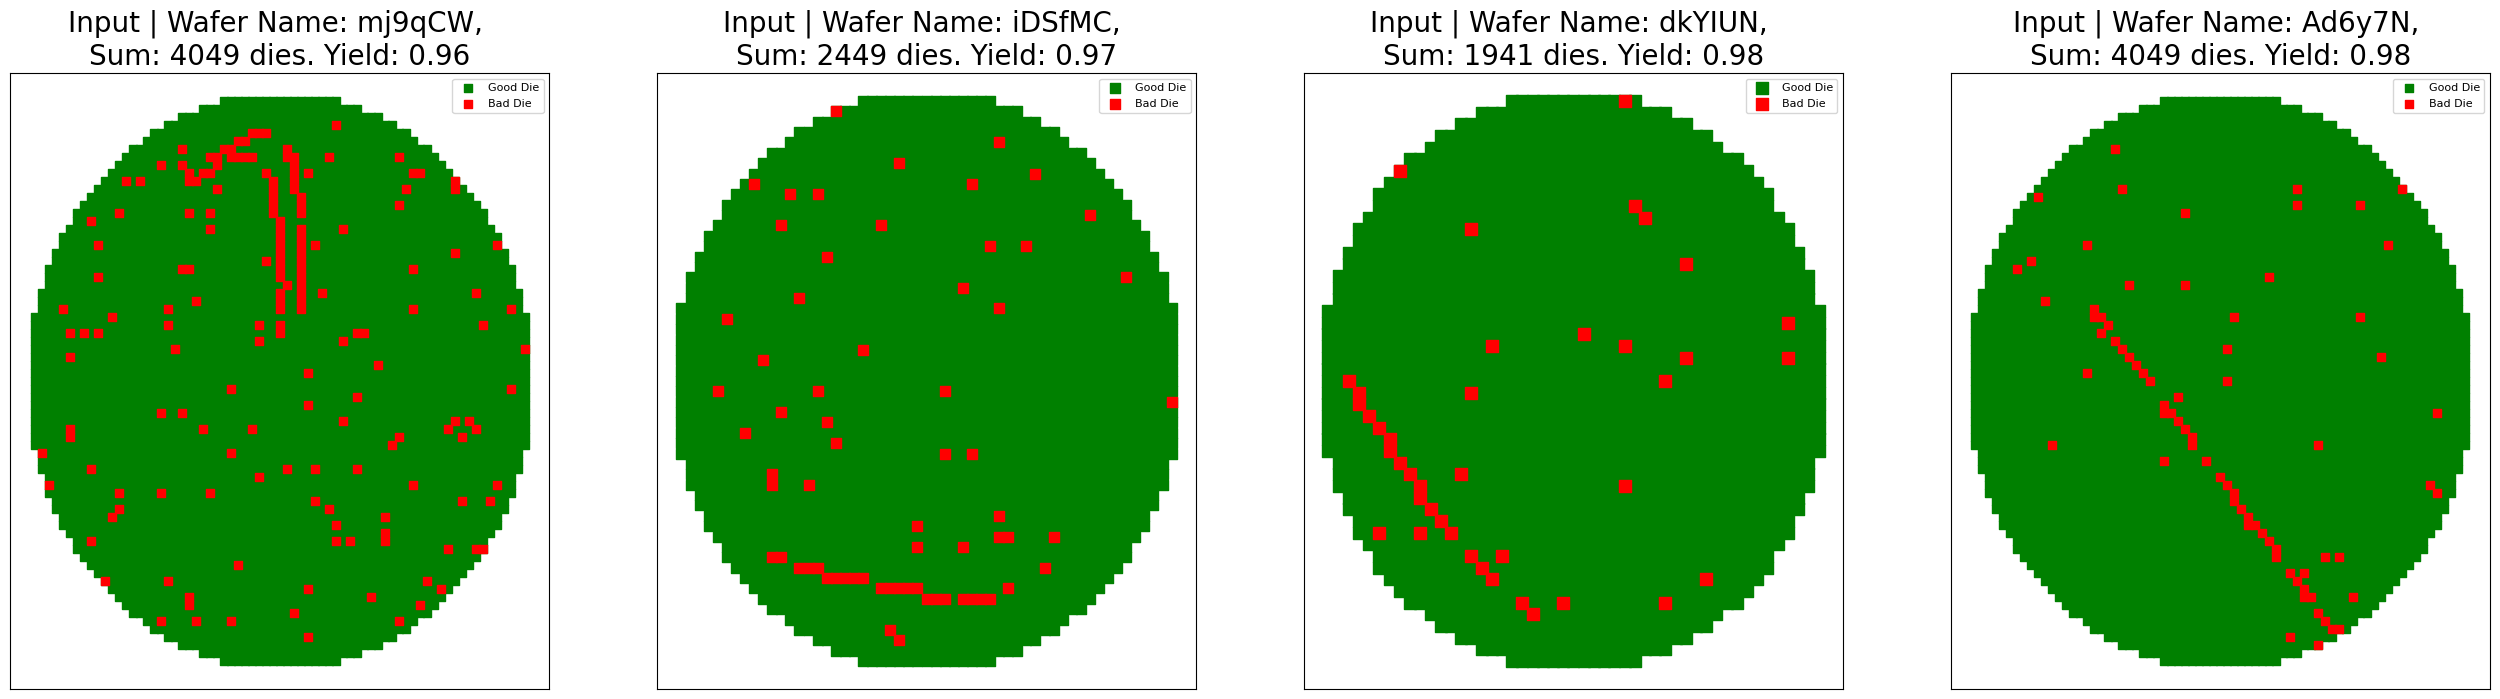

In [ ]:
list_sample_test = [df_wafers_test.groupby('WaferName').get_group(group) for group in df_wafers_test['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_test, figsize = 8, labels = False)

# Build your solution

In [ ]:
df_wafers.shape

(10415400, 5)

In [ ]:
df_wafers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415400 entries, 0 to 10415399
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   WaferName     object
 1   DieX          int64 
 2   DieY          int64 
 3   IsGoodDie     bool  
 4   IsScratchDie  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 258.3+ MB


In [ ]:
df_wafers.describe()

,DieX,DieY
count,1.041540e+07,1.041540e+07
mean,2.892736e+01,2.892736e+01
std,1.603043e+01,1.603043e+01
min,0.000000e+00,0.000000e+00
25%,1.600000e+01,1.600000e+01
50%,2.800000e+01,2.800000e+01
75%,4.100000e+01,4.100000e+01
max,7.000000e+01,7.000000e+01


In [ ]:
df_wafers.groupby('WaferName').count()

,DieX,DieY,IsGoodDie,IsScratchDie
WaferName,,,,
00Q792,1941,1941,1941,1941
01hHtd,1005,1005,1005,1005
042xYr,2449,2449,2449,2449
04XRmn,2997,2997,2997,2997
04kats,4049,4049,4049,4049
...,...,...,...,...
zr4aii,1005,1005,1005,1005
zuMuaC,3405,3405,3405,3405
zwa9Uv,1005,1005,1005,1005


In [ ]:
df_wafers.groupby('IsScratchDie').count()

,WaferName,DieX,DieY,IsGoodDie
IsScratchDie,,,,
False,10335081,10335081,10335081,10335081
True,80319,80319,80319,80319


In [ ]:
wafer_yield = df_wafers.groupby('WaferName').agg(
    total_dies=('IsGoodDie', 'count'),
    good_dies=('IsGoodDie', 'sum')
)
wafer_yield['Yield'] = wafer_yield['good_dies'] / wafer_yield['total_dies']

In [ ]:
wafer_yield.head()

,total_dies,good_dies,Yield
WaferName,,,
00Q792,1941,1881,0.969088
01hHtd,1005,978,0.973134
042xYr,2449,2363,0.964884
04XRmn,2997,2845,0.949283
04kats,4049,3880,0.958261


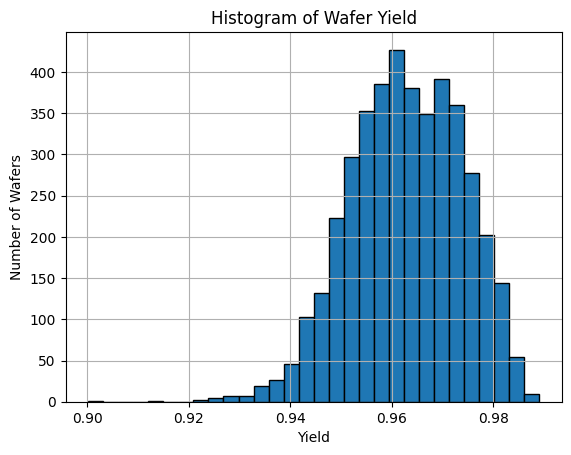

In [ ]:
plt.hist(wafer_yield['Yield'], bins=30, edgecolor='black')
plt.title("Histogram of Wafer Yield")
plt.xlabel("Yield")
plt.ylabel("Number of Wafers")
plt.grid(True)
plt.show()


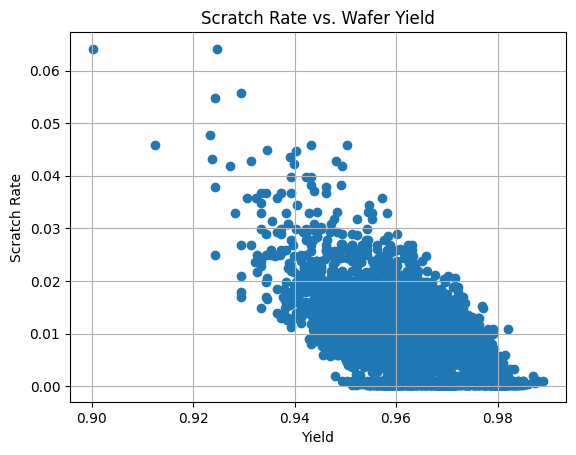

In [ ]:
df_scratch = df_wafers[df_wafers['IsScratchDie'] == 1]
scratch_yield = df_scratch.groupby('WaferName').size() / df_wafers.groupby('WaferName').size()

wafer_yield['ScratchRate'] = scratch_yield
plt.scatter(wafer_yield['Yield'], wafer_yield['ScratchRate'])
plt.xlabel("Yield")
plt.ylabel("Scratch Rate")
plt.title("Scratch Rate vs. Wafer Yield")
plt.grid(True)
plt.show()


In [ ]:
outlier_wafers = wafer_yield[
    (wafer_yield['Yield'] < 0.92) |
    (wafer_yield['ScratchRate'] > 0.045)
]

print(outlier_wafers[['Yield', 'ScratchRate']])

              Yield  ScratchRate
WaferName                       
5ANCVA     0.950249     0.045771
7Lyxe2     0.943284     0.045771
AvM0iw     0.912438     0.045771
SlGk2E     0.924653     0.064111
YouPKd     0.924378     0.054726
hyTuXj     0.929353     0.055721
sNyWi7     0.900198     0.064111
wgSX4O     0.923383     0.047761


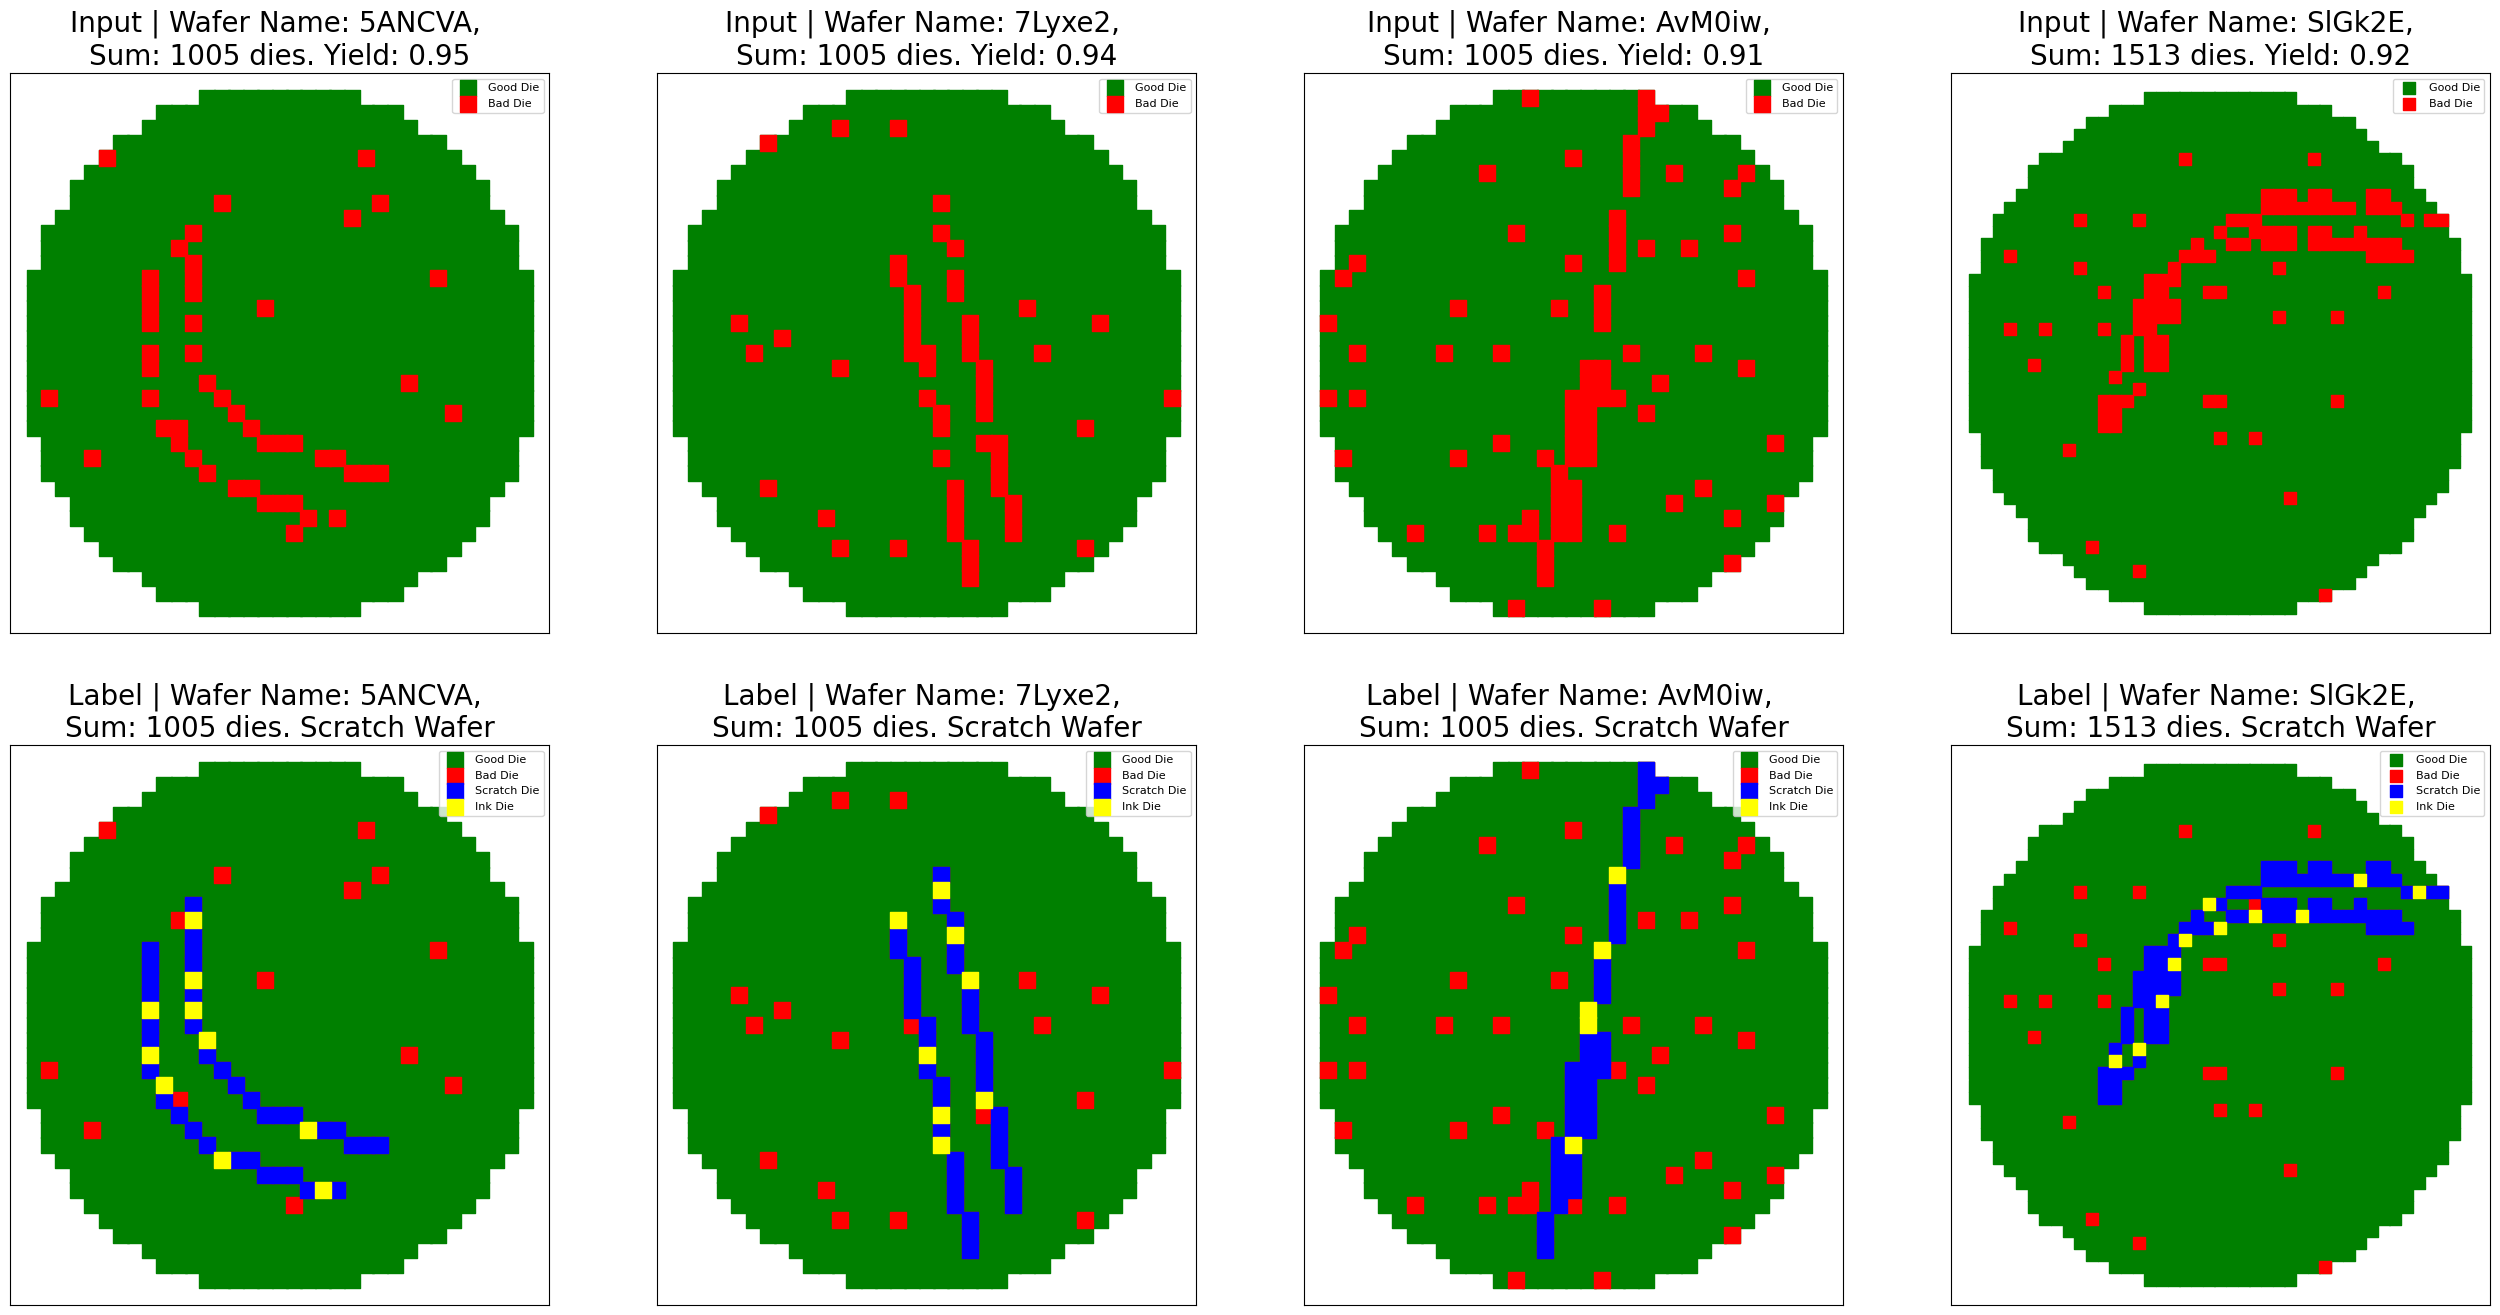

In [ ]:
outlier_wafer_names = outlier_wafers.index.tolist()

sample_outliers = df_wafers[df_wafers['WaferName'].isin(outlier_wafer_names)]
sampled_groups = [sample_outliers.groupby('WaferName').get_group(name) for name in outlier_wafer_names[:4]]

plot_wafer_maps(sampled_groups, figsize=8, labels=True)

In [ ]:
unique_wafers = df_wafers['WaferName'].unique()
wafers_train, wafers_val = train_test_split(unique_wafers, test_size=0.2, random_state=42)

df_train_base = df_wafers[df_wafers['WaferName'].isin(wafers_train)].copy()
df_val = df_wafers[df_wafers['WaferName'].isin(wafers_val)].copy()

df_train_full = df_train_base.copy()
df_train_filtered = df_train_base[~df_train_base['WaferName'].isin(outlier_wafer_names)].copy()


In [ ]:
def basic_features(df):
    features = df.copy()

    wafer_centers = features.groupby('WaferName')[['DieX', 'DieY']].mean().rename(columns={
        'DieX': 'CenterX', 'DieY': 'CenterY'
    })
    features = features.merge(wafer_centers, on='WaferName')
    features['DistFromCenter'] = ((features['DieX'] - features['CenterX'])**2 + (features['DieY'] - features['CenterY'])**2)**0.5

    features['NormX'] = features.groupby('WaferName')['DieX'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    features['NormY'] = features.groupby('WaferName')['DieY'].transform(lambda y: (y - y.min()) / (y.max() - y.min()))

    return features


In [ ]:
def add_neighbor_features(df):
    features = []
    for wafer_name, wafer_df in df.groupby("WaferName"):
        grid = {}
        for _, row in wafer_df.iterrows():
            grid[(row.DieX, row.DieY)] = row.IsGoodDie

        neighbors = []
        for _, row in wafer_df.iterrows():
            x, y = row.DieX, row.DieY
            neighbor_coords = [(x+i, y+j) for i in [-1, 0, 1] for j in [-1, 0, 1] if not (i == 0 and j == 0)]
            good_neighbors = sum(grid.get((nx, ny), 1) for nx, ny in neighbor_coords)  # מניח שדי תקין אם לא קיים
            bad_neighbors = 8 - good_neighbors
            neighbors.append(bad_neighbors)

        wafer_df = wafer_df.copy()
        wafer_df["BadNeighbors"] = neighbors
        features.append(wafer_df)

    return pd.concat(features, ignore_index=True)


In [ ]:
def prepare_ml_data(df):
    df = basic_features(df)
    df = add_neighbor_features(df)
    feature_cols = ['NormX', 'NormY', 'DistFromCenter', 'BadNeighbors', 'IsGoodDie']
    X = df[feature_cols]
    y = df['IsScratchDie']
    return X, y


In [ ]:
X_train_full, y_train_full = prepare_ml_data(df_train_full)
X_train_filtered, y_train_filtered = prepare_ml_data(df_train_filtered)
X_val, y_val = prepare_ml_data(df_val)


In [ ]:
model_full = RandomForestClassifier(random_state=42)
model_full.fit(X_train_full, y_train_full)
y_pred_full = model_full.predict(X_val)

model_filtered = RandomForestClassifier(random_state=42)
model_filtered.fit(X_train_filtered, y_train_filtered)
y_pred_filtered = model_filtered.predict(X_val)

print("=== Model Trained on Full Dataset ===")
print(classification_report(y_val, y_pred_full))

print("\n=== Model Trained on Filtered Dataset (No Outliers) ===")
print(classification_report(y_val, y_pred_filtered))


=== Model Trained on Full Dataset ===
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   2090268
        True       0.72      0.55      0.62     16840

    accuracy                           0.99   2107108
   macro avg       0.86      0.77      0.81   2107108
weighted avg       0.99      0.99      0.99   2107108


=== Model Trained on Filtered Dataset (No Outliers) ===
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   2090268
        True       0.72      0.55      0.62     16840

    accuracy                           0.99   2107108
   macro avg       0.86      0.77      0.81   2107108
weighted avg       0.99      0.99      0.99   2107108



In [ ]:
y_train_pred = model_filtered.predict(X_train_filtered)

print("=== Train Set ===")
print(classification_report(y_train_filtered, y_train_pred))

print("\n=== Validation Set ===")
print(classification_report(y_val, y_pred_filtered))

=== Train Set ===
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   8237664
        True       0.85      0.64      0.73     63085

    accuracy                           1.00   8300749
   macro avg       0.92      0.82      0.86   8300749
weighted avg       1.00      1.00      1.00   8300749


=== Validation Set ===
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   2090268
        True       0.72      0.55      0.62     16840

    accuracy                           0.99   2107108
   macro avg       0.86      0.77      0.81   2107108
weighted avg       0.99      0.99      0.99   2107108



In [ ]:
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)

model_rf.fit(X_train_filtered, y_train_filtered)
y_pred_rf = model_rf.predict(X_val)

print("=== Random Forest (Balanced Class Weights) ===")
print(classification_report(y_val, y_pred_rf))

=== Random Forest (Balanced Class Weights) ===
              precision    recall  f1-score   support

       False       1.00      0.98      0.99   2090268
        True       0.25      0.73      0.37     16840

    accuracy                           0.98   2107108
   macro avg       0.62      0.86      0.68   2107108
weighted avg       0.99      0.98      0.98   2107108



In [ ]:
y_train_pred = model_rf.predict(X_train_filtered)

print("=== Train Set ===")
print(classification_report(y_train_filtered, y_train_pred))

print("\n=== Validation Set ===")
print(classification_report(y_val, model_rf.predict(X_val)))


=== Train Set ===
              precision    recall  f1-score   support

       False       1.00      0.98      0.99   8237664
        True       0.30      0.97      0.46     63085

    accuracy                           0.98   8300749
   macro avg       0.65      0.97      0.72   8300749
weighted avg       0.99      0.98      0.99   8300749


=== Validation Set ===
              precision    recall  f1-score   support

       False       1.00      0.98      0.99   2090268
        True       0.25      0.73      0.37     16840

    accuracy                           0.98   2107108
   macro avg       0.62      0.86      0.68   2107108
weighted avg       0.99      0.98      0.98   2107108



In [ ]:
models = {

    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_filtered, y_train_filtered)

    y_val_pred = model.predict(X_val)

    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, pos_label=1, average='binary')

    results.append({
        'Model': name,
        'Precision (True)': round(precision, 3),
        'Recall (True)': round(recall, 3),
        'F1-Score (True)': round(f1, 3)
    })

results_df = pd.DataFrame(results)
print(results_df)

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:52:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training LightGBM...
[LightGBM] [Info] Number of positive: 63085, number of negative: 8237664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.945959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 8300749, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007600 -> initscore=-4.871989
[LightGBM] [Info] Start training from score -4.871989
Training LogisticRegression...
                Model  Precision (True)  Recall (True)  F1-Score (True)
0             XGBoost             0.801          0.570            0.666
1            LightGBM             0.767          0.570            0.654
2  LogisticRegression             0.793          0.565            0.660


In [ ]:
pos_weight = (y_train_filtered == 0).sum() / (y_train_filtered == 1).sum()

models = {

    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=pos_weight, random_state=42),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_filtered, y_train_filtered)

    y_val_pred = model.predict(X_val)

    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, pos_label=1, average='binary')

    results.append({
        'Model': name,
        'Precision (True)': round(precision, 3),
        'Recall (True)': round(recall, 3),
        'F1-Score (True)': round(f1, 3)
    })

results_df = pd.DataFrame(results)
print(results_df)

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:00:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training LightGBM...
[LightGBM] [Info] Number of positive: 63085, number of negative: 8237664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.767554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 8300749, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training LogisticRegression...
                Model  Precision (True)  Recall (True)  F1-Score (True)
0             XGBoost             0.133          0.943            0.234
1            LightGBM             0.121          0.955            0.215
2  LogisticRegression             0.108          0.957            0.194


In [ ]:
model_names = ['XGBoost', 'LightGBM', 'LogisticRegression']

best_thresholds = []
adjusted_results = []

for name, model in models.items():
    print(f"Finding best threshold for {name}...")

    y_val_scores = model.predict_proba(X_val)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_scores)

    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    best_f1 = f1_scores[best_index]

    best_thresholds.append((name, best_threshold, best_f1))

    y_val_pred_adjusted = (y_val_scores >= best_threshold).astype(int)

    precision_new, recall_new, f1_new, _ = precision_recall_fscore_support(
        y_val, y_val_pred_adjusted, pos_label=1, average='binary'
    )

    adjusted_results.append({
        'Model': name,
        'Best Threshold': round(best_threshold, 3),
        'Precision (True)': round(precision_new, 3),
        'Recall (True)': round(recall_new, 3),
        'F1-Score (True)': round(f1_new, 3)
    })

adjusted_results_df = pd.DataFrame(adjusted_results)
print(adjusted_results_df)

Finding best threshold for XGBoost...
Finding best threshold for LightGBM...
Finding best threshold for LogisticRegression...
                Model  Best Threshold  Precision (True)  Recall (True)  \
0             XGBoost           0.986             0.734          0.621   
1            LightGBM           0.982             0.689          0.654   
2  LogisticRegression           0.995             0.689          0.582   

   F1-Score (True)  
0            0.673  
1            0.671  
2            0.631  


In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_filtered, y_train_filtered)

print(f"Original training size: {len(X_train_filtered)}")
print(f"After SMOTE training size: {len(X_train_smote)}")

model_xgb_smote = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model_xgb_smote.fit(X_train_smote, y_train_smote)

y_val_pred_smote = model_xgb_smote.predict(X_val)

from sklearn.metrics import classification_report
print("\n=== XGBoost + SMOTE Validation Performance ===")
print(classification_report(y_val, y_val_pred_smote))


Original training size: 8300749
After SMOTE training size: 16475328


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:12:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost + SMOTE Validation Performance ===
              precision    recall  f1-score   support

       False       1.00      0.96      0.98   2090268
        True       0.15      0.93      0.25     16840

    accuracy                           0.96   2107108
   macro avg       0.57      0.94      0.62   2107108
weighted avg       0.99      0.96      0.97   2107108



Best threshold after SMOTE: 0.9798
Best F1-score after SMOTE: 0.6699


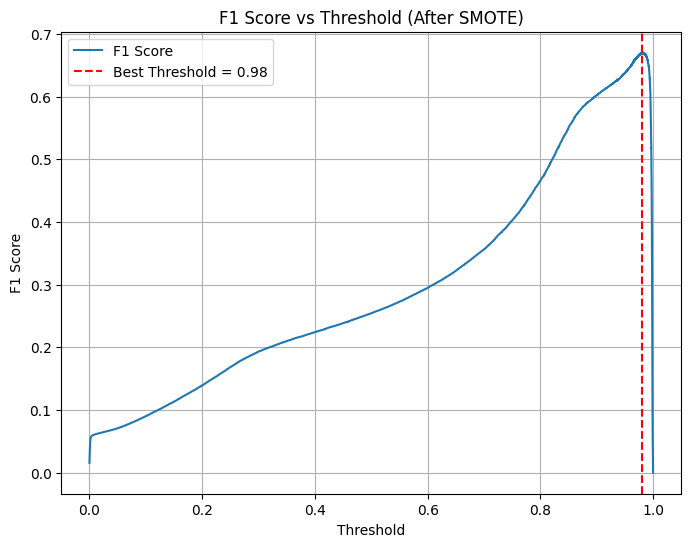

In [ ]:
y_val_scores_smote = model_xgb_smote.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_scores_smote)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_idx = np.argmax(f1_scores)
best_threshold_smote = thresholds[best_idx]
best_f1_smote = f1_scores[best_idx]

print(f"Best threshold after SMOTE: {best_threshold_smote:.4f}")
print(f"Best F1-score after SMOTE: {best_f1_smote:.4f}")

plt.figure(figsize=(8,6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(x=best_threshold_smote, color='red', linestyle='--', label=f'Best Threshold = {best_threshold_smote:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold (After SMOTE)')
plt.legend()
plt.grid()
plt.show()


I explored multiple approaches to the task of scratch detection on semiconductor wafers.
Initially trained different models — including Random Forest, XGBoost, LightGBM, and Logistic Regression — using engineered features such as normalized die positions and distance from wafer center.

To address the significant class imbalance (few scratched dies compared to many good dies), I evaluated different strategies:

Using class_weight='balanced',

Applying SMOTE (Synthetic Minority Oversampling Technique) to synthetically balance the dataset,

Fine-tuning the prediction threshold to maximize the F1-Score.

After comprehensive experiments, I found that XGBoost trained without SMOTE, but using an optimized threshold (≈ 0.986), achieved the best trade-off between Precision and Recall.

This model achieved a Precision of ~73%, a Recall of ~62%, and a F1-Score of ~0.67 on the validation set.

Using SMOTE improved recall but significantly reduced precision, leading to too many false positives, which is undesirable in this business context where over-inking is costly.

Given that precision is critical in scratch detection — to avoid unnecessary "inking" of good dies and minimize production costs — I decided to use the XGBoost model trained without SMOTE, combined with a best threshold of 0.986 for final predictions.

This setup offers the best balance between catching true scratches and minimizing false alarms, aligning well with business goals.

# Additional thoughts

# **Deep Learning**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from datetime import datetime

In [ ]:
class UNetResNet(nn.Module):
    def __init__(self, encoder_name='resnet18', pretrained=True):
        super(UNetResNet, self).__init__()

        if encoder_name == 'resnet18':
            self.encoder = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
            encoder_channels = [64, 64, 128, 256, 512]
        elif encoder_name == 'resnet34':
            self.encoder = models.resnet34(weights='IMAGENET1K_V1' if pretrained else None)
            encoder_channels = [64, 64, 128, 256, 512]
        else:
            raise ValueError('Unsupported encoder')

        self.base_layers = nn.Sequential(*list(self.encoder.children())[:-2])

        self.up4 = self._up_block(encoder_channels[4], encoder_channels[3])
        self.up3 = self._up_block(encoder_channels[3], encoder_channels[2])
        self.up2 = self._up_block(encoder_channels[2], encoder_channels[1])
        self.up1 = self._up_block(encoder_channels[1], encoder_channels[0])
        self.up0 = self._up_block(encoder_channels[0], encoder_channels[0] // 2)

        self.final_conv = nn.Conv2d(encoder_channels[0] // 2, 1, kernel_size=1)

    def _up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.maxpool(x1)
        x2 = self.encoder.layer1(x1)
        x3 = self.encoder.layer2(x2)
        x4 = self.encoder.layer3(x3)
        x5 = self.encoder.layer4(x4)

        d4 = self.up4(x5) + x4
        d3 = self.up3(d4) + x3
        d2 = self.up2(d3) + x2
        d1 = self.up1(d2)
        d0 = self.up0(d1)

        out = self.final_conv(d0)
        out = torch.sigmoid(out)
        return out


def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    loss = 1 - ((2. * intersection + smooth) /
                (pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + smooth))
    return loss.mean()

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCELoss()

    def forward(self, pred, target):
        bce = self.bce(pred, target)
        dice = dice_loss(pred, target)
        return bce + dice


class WaferRawDataset(Dataset):
    def __init__(self, wafer_groups, output_size=(64, 64)):
        self.wafer_names = list(wafer_groups.keys())
        self.wafer_groups = wafer_groups
        self.output_size = output_size

    def __len__(self):
        return len(self.wafer_names)

    def __getitem__(self, idx):
        wafer_name = self.wafer_names[idx]
        wafer_df = self.wafer_groups[wafer_name]

        wafer_map = self.create_raw_wafer(wafer_df)
        target_map = self.create_target_wafer(wafer_df)

        return wafer_map, target_map

    def create_raw_wafer(self, df):
        x = df['DieX'].values
        y = df['DieY'].values
        is_good = df['IsGoodDie'].astype(np.float32).values

        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()

        grid_width = xmax - xmin + 1
        grid_height = ymax - ymin + 1

        grid_x = np.ones((grid_height, grid_width)) * -1
        grid_y = np.ones((grid_height, grid_width)) * -1
        grid_is_good = np.ones((grid_height, grid_width)) * -1

        for i in range(len(df)):
            xi = x[i] - xmin
            yi = y[i] - ymin
            grid_x[yi, xi] = x[i]
            grid_y[yi, xi] = y[i]
            grid_is_good[yi, xi] = is_good[i]

        wafer = np.stack([grid_x, grid_y, grid_is_good], axis=0)

        wafer[0] = (wafer[0] - wafer[0].min()) / (wafer[0].max() - wafer[0].min() + 1e-8)
        wafer[1] = (wafer[1] - wafer[1].min()) / (wafer[1].max() - wafer[1].min() + 1e-8)

        wafer = torch.tensor(wafer, dtype=torch.float32)
        wafer = F.interpolate(wafer.unsqueeze(0), size=self.output_size, mode='bilinear', align_corners=True).squeeze(0)
        return wafer

    def create_target_wafer(self, df):
        x = df['DieX'].values
        y = df['DieY'].values
        is_scratch = df['IsScratchDie'].astype(np.float32).values

        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()

        grid_width = xmax - xmin + 1
        grid_height = ymax - ymin + 1

        grid_label = np.zeros((grid_height, grid_width))

        for i in range(len(df)):
            xi = x[i] - xmin
            yi = y[i] - ymin
            grid_label[yi, xi] = is_scratch[i]

        label = torch.tensor(grid_label, dtype=torch.float32).unsqueeze(0)
        label = F.interpolate(label.unsqueeze(0), size=self.output_size, mode='nearest').squeeze(0)
        return label


def train_unet(model, train_loader, val_loader, criterion, optimizer, n_epochs=30, patience=5, device='cuda'):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, n_epochs+1):
        model.train()
        train_losses = []
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False):
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False):
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)

        print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_unet_model.pth')
            print("✅ Best model saved.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹ Early stopping triggered.")
                break

    print("✅ Training complete!")


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNetResNet(encoder_name='resnet18', pretrained=True).to(device)
criterion = BCEDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_wafer_groups = {wafer_name: wafer_df for wafer_name, wafer_df in df_wafers.groupby('WaferName')}
val_wafer_groups = {wafer_name: wafer_df for wafer_name, wafer_df in df_val.groupby('WaferName')}


train_dataset = WaferRawDataset(train_wafer_groups)
val_dataset = WaferRawDataset(val_wafer_groups)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

train_unet(model, train_loader, val_loader, criterion, optimizer, n_epochs=100, patience=7, device=device)

Epoch 1 | Train Loss: 0.9034 | Val Loss: 0.7209
✅ Best model saved.


Epoch 2 | Train Loss: 0.6574 | Val Loss: 0.6173
✅ Best model saved.


Epoch 3 | Train Loss: 0.5867 | Val Loss: 0.5632
✅ Best model saved.


Epoch 4 | Train Loss: 0.5563 | Val Loss: 0.5400
✅ Best model saved.


Epoch 5 | Train Loss: 0.5731 | Val Loss: 0.5598


Epoch 6 | Train Loss: 0.5316 | Val Loss: 0.5191
✅ Best model saved.


Epoch 7 | Train Loss: 0.4966 | Val Loss: 0.4900
✅ Best model saved.


Epoch 8 | Train Loss: 0.4864 | Val Loss: 0.4761
✅ Best model saved.


Epoch 9 | Train Loss: 0.4717 | Val Loss: 0.4669
✅ Best model saved.


Epoch 10 | Train Loss: 0.4655 | Val Loss: 0.4598
✅ Best model saved.


Epoch 11 | Train Loss: 0.4532 | Val Loss: 0.4454
✅ Best model saved.


Epoch 12 | Train Loss: 0.4442 | Val Loss: 0.4400
✅ Best model saved.


Epoch 13 | Train Loss: 0.4370 | Val Loss: 0.4432


Epoch 14 | Train Loss: 0.4327 | Val Loss: 0.4304
✅ Best model saved.


Epoch 15 | Train Loss: 0.4238 | Val Loss: 0.4204
✅ Best model saved.


Epoch 16 | Train Loss: 0.4172 | Val Loss: 0.4078
✅ Best model saved.


Epoch 17 | Train Loss: 0.4077 | Val Loss: 0.4020
✅ Best model saved.


Epoch 18 | Train Loss: 0.4117 | Val Loss: 0.3952
✅ Best model saved.


Epoch 19 | Train Loss: 0.4012 | Val Loss: 0.3912
✅ Best model saved.


Epoch 20 | Train Loss: 0.3937 | Val Loss: 0.3888
✅ Best model saved.


Epoch 21 | Train Loss: 0.4078 | Val Loss: 0.3871
✅ Best model saved.


Epoch 22 | Train Loss: 0.3902 | Val Loss: 0.3866
✅ Best model saved.


Epoch 23 | Train Loss: 0.3816 | Val Loss: 0.3742
✅ Best model saved.


Epoch 24 | Train Loss: 0.3798 | Val Loss: 0.3704
✅ Best model saved.


Epoch 25 | Train Loss: 0.3733 | Val Loss: 0.3655
✅ Best model saved.


Epoch 26 | Train Loss: 0.3744 | Val Loss: 0.3671


Epoch 27 | Train Loss: 0.3697 | Val Loss: 0.3606
✅ Best model saved.


Epoch 28 | Train Loss: 0.3662 | Val Loss: 0.3578
✅ Best model saved.


Epoch 29 | Train Loss: 0.3619 | Val Loss: 0.3482
✅ Best model saved.


Epoch 30 | Train Loss: 0.3572 | Val Loss: 0.3510


Epoch 31 | Train Loss: 0.3587 | Val Loss: 0.3529


Epoch 32 | Train Loss: 0.3570 | Val Loss: 0.3606


Epoch 33 | Train Loss: 0.3616 | Val Loss: 0.3493


Epoch 34 | Train Loss: 0.3537 | Val Loss: 0.3423
✅ Best model saved.


Epoch 35 | Train Loss: 0.3487 | Val Loss: 0.3447


Epoch 36 | Train Loss: 0.3507 | Val Loss: 0.3375
✅ Best model saved.


Epoch 37 | Train Loss: 0.3445 | Val Loss: 0.3397


Epoch 38 | Train Loss: 0.3407 | Val Loss: 0.3430


Epoch 39 | Train Loss: 0.3409 | Val Loss: 0.3321
✅ Best model saved.


Epoch 40 | Train Loss: 0.3439 | Val Loss: 0.3453


Epoch 41 | Train Loss: 0.3412 | Val Loss: 0.3320
✅ Best model saved.


Epoch 42 | Train Loss: 0.3372 | Val Loss: 0.3258
✅ Best model saved.


Epoch 43 | Train Loss: 0.3373 | Val Loss: 0.3290


Epoch 44 | Train Loss: 0.3337 | Val Loss: 0.3286


Epoch 45 | Train Loss: 0.3316 | Val Loss: 0.3541


Epoch 46 | Train Loss: 0.3421 | Val Loss: 0.3257
✅ Best model saved.


Epoch 47 | Train Loss: 0.3350 | Val Loss: 0.3292


Epoch 48 | Train Loss: 0.3276 | Val Loss: 0.3184
✅ Best model saved.


Epoch 49 | Train Loss: 0.3264 | Val Loss: 0.3156
✅ Best model saved.


Epoch 50 | Train Loss: 0.3243 | Val Loss: 0.3201


Epoch 51 | Train Loss: 0.3245 | Val Loss: 0.3159


Epoch 52 | Train Loss: 0.3222 | Val Loss: 0.3247


Epoch 53 | Train Loss: 0.3350 | Val Loss: 0.3355


Epoch 54 | Train Loss: 0.3261 | Val Loss: 0.3250


Epoch 55 | Train Loss: 0.3240 | Val Loss: 0.3179


Epoch 56 | Train Loss: 0.3197 | Val Loss: 0.3128
✅ Best model saved.


Epoch 57 | Train Loss: 0.3204 | Val Loss: 0.3161


Epoch 58 | Train Loss: 0.3167 | Val Loss: 0.3092
✅ Best model saved.


Epoch 59 | Train Loss: 0.3158 | Val Loss: 0.3165


Epoch 60 | Train Loss: 0.3192 | Val Loss: 0.3084
✅ Best model saved.


Epoch 61 | Train Loss: 0.3142 | Val Loss: 0.3081
✅ Best model saved.


Epoch 62 | Train Loss: 0.3145 | Val Loss: 0.3148


Epoch 63 | Train Loss: 0.3158 | Val Loss: 0.3032
✅ Best model saved.


Epoch 64 | Train Loss: 0.3114 | Val Loss: 0.3101


Epoch 65 | Train Loss: 0.3129 | Val Loss: 0.3125


Epoch 66 | Train Loss: 0.3116 | Val Loss: 0.3122


Epoch 67 | Train Loss: 0.3140 | Val Loss: 0.3087


Epoch 68 | Train Loss: 0.3104 | Val Loss: 0.3064


Epoch 69 | Train Loss: 0.3096 | Val Loss: 0.3018
✅ Best model saved.


Epoch 70 | Train Loss: 0.3079 | Val Loss: 0.3002
✅ Best model saved.


Epoch 71 | Train Loss: 0.3063 | Val Loss: 0.3051


Epoch 72 | Train Loss: 0.3070 | Val Loss: 0.2986
✅ Best model saved.


Epoch 73 | Train Loss: 0.3067 | Val Loss: 0.3037


Epoch 74 | Train Loss: 0.3045 | Val Loss: 0.3013


Epoch 75 | Train Loss: 0.3056 | Val Loss: 0.2963
✅ Best model saved.


Epoch 76 | Train Loss: 0.3068 | Val Loss: 0.3014


Epoch 77 | Train Loss: 0.3045 | Val Loss: 0.2943
✅ Best model saved.


Epoch 78 | Train Loss: 0.3024 | Val Loss: 0.2956


Epoch 79 | Train Loss: 0.3010 | Val Loss: 0.2918
✅ Best model saved.


Epoch 80 | Train Loss: 0.3052 | Val Loss: 0.2945


Epoch 81 | Train Loss: 0.3406 | Val Loss: 0.3482


Epoch 82 | Train Loss: 0.3130 | Val Loss: 0.2952


Epoch 83 | Train Loss: 0.2987 | Val Loss: 0.2868
✅ Best model saved.


Epoch 84 | Train Loss: 0.2942 | Val Loss: 0.2875


Epoch 85 | Train Loss: 0.2937 | Val Loss: 0.2986


Epoch 86 | Train Loss: 0.2931 | Val Loss: 0.2857
✅ Best model saved.


Epoch 87 | Train Loss: 0.2947 | Val Loss: 0.2910


Epoch 88 | Train Loss: 0.2939 | Val Loss: 0.2871


Epoch 89 | Train Loss: 0.2943 | Val Loss: 0.2889


Epoch 90 | Train Loss: 0.2931 | Val Loss: 0.2870


Epoch 91 | Train Loss: 0.2932 | Val Loss: 0.2853
✅ Best model saved.


Epoch 92 | Train Loss: 0.2934 | Val Loss: 0.2965


Epoch 93 | Train Loss: 0.2962 | Val Loss: 0.2852
✅ Best model saved.


Epoch 94 | Train Loss: 0.2953 | Val Loss: 0.2875


Epoch 95 | Train Loss: 0.2930 | Val Loss: 0.2880


Epoch 96 | Train Loss: 0.2924 | Val Loss: 0.2938


Epoch 97 | Train Loss: 0.2947 | Val Loss: 0.2913


Epoch 98 | Train Loss: 0.2918 | Val Loss: 0.2837
✅ Best model saved.


Epoch 99 | Train Loss: 0.2920 | Val Loss: 0.2889


Epoch 100 | Train Loss: 0.2926 | Val Loss: 0.2941
✅ Training complete!


In [ ]:
def predict_unet(model, dataloader, device='cuda', threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            preds = model(xb)
            preds = preds.cpu().numpy()
            targets = yb.numpy()

            preds = preds.reshape(preds.shape[0], -1)
            targets = targets.reshape(targets.shape[0], -1)

            all_preds.append(preds)
            all_targets.append(targets)

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    pred_labels = (all_preds >= threshold).astype(int)
    target_labels = (all_targets >= 0.5).astype(int)

    return pred_labels, target_labels

def evaluate_performance(pred_labels, target_labels):
    precision, recall, f1, _ = precision_recall_fscore_support(
        target_labels.flatten(), pred_labels.flatten(), average='binary'
    )

    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1-Score: {f1:.4f}")

    print("\n=== Classification Report ===")
    print(classification_report(target_labels.flatten(), pred_labels.flatten()))

def plot_wafer_predictions(model, dataset, device='cuda', n_samples=3, threshold=0.5):
    model.eval()
    idxs = np.random.choice(len(dataset), n_samples, replace=False)

    fig, axes = plt.subplots(n_samples, 2, figsize=(8, 4 * n_samples))

    for i, idx in enumerate(idxs):
        xb, yb = dataset[idx]
        xb_input = xb.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(xb_input).cpu().squeeze(0).squeeze(0).numpy()

        pred_binary = (pred >= threshold).astype(int)
        true_binary = yb.squeeze(0).numpy()

        axes[i, 0].imshow(true_binary, cmap='gray')
        axes[i, 0].set_title("True Mask")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(pred_binary, cmap='gray')
        axes[i, 1].set_title("Predicted Mask")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.load_state_dict(torch.load('best_unet_model.pth'))
model.to(device)

pred_labels, target_labels = predict_unet(model, val_loader, device=device, threshold=0.5)

evaluate_performance(pred_labels, target_labels)


✅ Precision: 0.8038
✅ Recall: 0.8508
✅ F1-Score: 0.8266

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3415486
           1       0.80      0.85      0.83     25154

    accuracy                           1.00   3440640
   macro avg       0.90      0.92      0.91   3440640
weighted avg       1.00      1.00      1.00   3440640



In [ ]:
def find_best_threshold(y_scores, y_true):
    """
    Finds the best threshold that maximizes the F1-Score.
    """
    precision, recall, thresholds = precision_recall_curve(y_true.flatten(), y_scores.flatten())
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    print(f"✅ Best Threshold: {best_threshold:.4f}")
    print(f"✅ Best F1-Score: {best_f1:.4f}")

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.scatter(recall[best_idx], precision[best_idx], marker='o', color='red', label=f'Best Threshold {best_threshold:.4f}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.load_state_dict(torch.load('best_unet_model.pth'))
model.to(device)
model.eval()

all_scores = []
all_targets = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = model(xb)
        preds = preds.cpu().numpy()
        yb = yb.numpy()

        preds = preds.reshape(preds.shape[0], -1)
        yb = yb.reshape(yb.shape[0], -1)

        all_scores.append(preds)
        all_targets.append(yb)

y_scores_flat = np.concatenate(all_scores, axis=0).flatten()
y_true_flat = np.concatenate(all_targets, axis=0).flatten()


✅ Best Threshold: 0.5393
✅ Best F1-Score: 0.8271


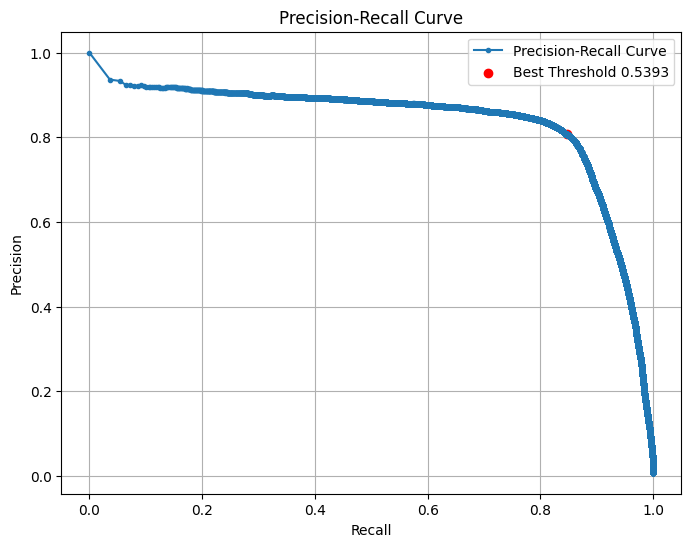

In [ ]:
best_threshold = find_best_threshold(y_scores_flat, y_true_flat)

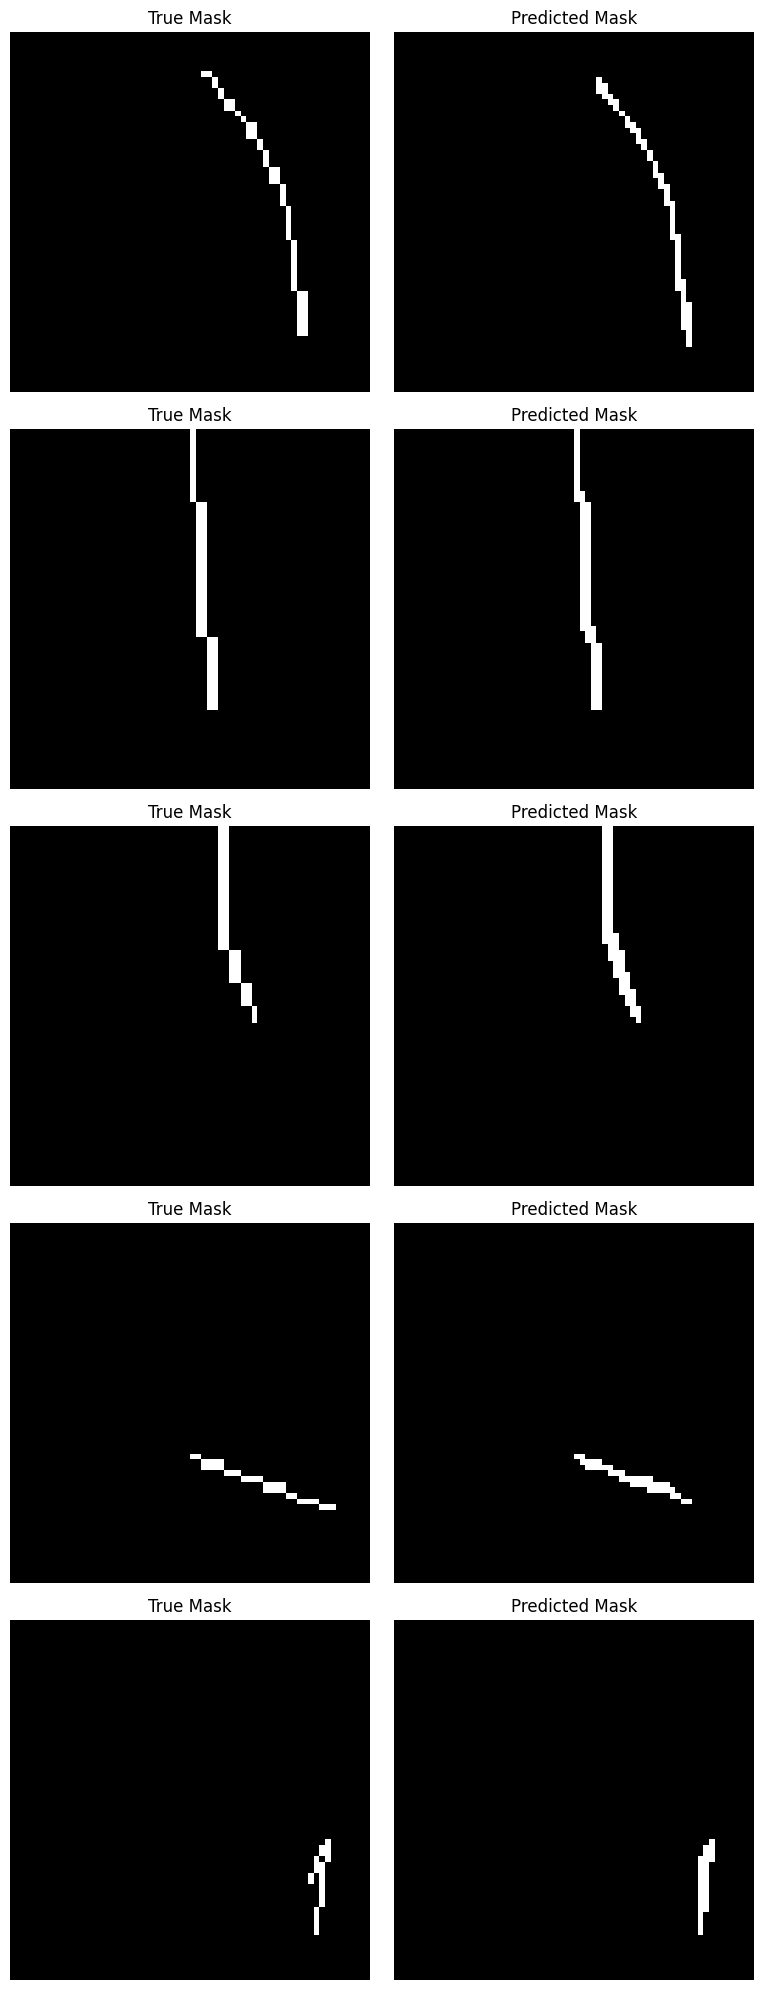

In [ ]:
plot_wafer_predictions(model, val_dataset, device=device, n_samples=5, threshold=0.5)


 After experimenting with multiple models — including Random Forests, XGBoost, LightGBM, and logistic regression I developed a deep learning-based segmentation approach using a U-Net architecture with a ResNet encoder. This model achieved the best balance between precision and recall.

Final Performance (Validation Set):

Precision (True Class): 0.80

Recall (True Class): 0.85

F1-Score (True Class): 0.83

Accuracy: ~1.00 (expected due to class imbalance)

These results indicate that the model is both accurate and cautious, successfully detecting the majority of scratch-related dies while minimizing false positives.



# Submission

In [ ]:
class WaferRawTestDataset(Dataset):
    def __init__(self, wafer_groups, output_size=(64, 64)):
        self.wafer_names = list(wafer_groups.keys())
        self.wafer_groups = wafer_groups
        self.output_size = output_size

    def __len__(self):
        return len(self.wafer_names)

    def __getitem__(self, idx):
        wafer_name = self.wafer_names[idx]
        wafer_df = self.wafer_groups[wafer_name]

        wafer_map = self.create_raw_wafer(wafer_df)

        return wafer_name, wafer_map

    def create_raw_wafer(self, df):
        x = df['DieX'].values
        y = df['DieY'].values
        is_good = df['IsGoodDie'].astype(np.float32).values

        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()

        grid_width = xmax - xmin + 1
        grid_height = ymax - ymin + 1

        grid_x = np.ones((grid_height, grid_width)) * -1
        grid_y = np.ones((grid_height, grid_width)) * -1
        grid_is_good = np.ones((grid_height, grid_width)) * -1

        for i in range(len(df)):
            xi = x[i] - xmin
            yi = y[i] - ymin
            grid_x[yi, xi] = x[i]
            grid_y[yi, xi] = y[i]
            grid_is_good[yi, xi] = is_good[i]

        wafer = np.stack([grid_x, grid_y, grid_is_good], axis=0)

        wafer[0] = (wafer[0] - wafer[0].min()) / (wafer[0].max() - wafer[0].min() + 1e-8)
        wafer[1] = (wafer[1] - wafer[1].min()) / (wafer[1].max() - wafer[1].min() + 1e-8)

        wafer = torch.tensor(wafer, dtype=torch.float32)
        wafer = F.interpolate(wafer.unsqueeze(0), size=self.output_size, mode='bilinear', align_corners=True).squeeze(0)
        return wafer


In [ ]:
wafer_groups_test = {w: d for w, d in df_wafers_test.groupby('WaferName')}

test_dataset = WaferRawTestDataset(wafer_groups_test, output_size=(64, 64))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)


model.eval()
model.to(device)

wafer_preds = []
wafer_names = []

with torch.no_grad():
    for wafer_name, xb in tqdm(test_loader, desc="Predicting"):
        xb = xb.to(device)
        preds = model(xb).cpu().squeeze(0).squeeze(0).numpy()
        wafer_preds.append(preds)
        wafer_names.append(wafer_name[0])


wafer_names = list(wafer_groups_test.keys())

all_preds = []

for wafer_name, pred_map in zip(wafer_names, wafer_preds):
    wafer_df = df_wafers_test[df_wafers_test['WaferName'] == wafer_name]

    x_min, x_max = wafer_df['DieX'].min(), wafer_df['DieX'].max()
    y_min, y_max = wafer_df['DieY'].min(), wafer_df['DieY'].max()

    grid_width = x_max - x_min + 1
    grid_height = y_max - y_min + 1

    scale_x = pred_map.shape[1] / grid_width
    scale_y = pred_map.shape[0] / grid_height

    preds = []
    for _, row in wafer_df.iterrows():
        x = int((row['DieX'] - x_min) * scale_x)
        y = int((row['DieY'] - y_min) * scale_y)
        x = np.clip(x, 0, pred_map.shape[1]-1)
        y = np.clip(y, 0, pred_map.shape[0]-1)
        preds.append(pred_map[y, x])

    all_preds.extend(preds)

threshold = best_threshold
final_preds = (np.array(all_preds) >= threshold).astype(int)

df_wafers_test = df_wafers_test.copy()
df_wafers_test['IsScratchDie'] = final_preds

low_yield_threshold = 0.6
wafer_yield = df_wafers_test.groupby('WaferName')['IsGoodDie'].mean()
low_yield_wafers = wafer_yield[wafer_yield < low_yield_threshold].index.tolist()

print(f"Found {len(low_yield_wafers)} low-yield wafers. Setting IsScratchDie = 0 for them.")

df_wafers_test.loc[df_wafers_test['WaferName'].isin(low_yield_wafers), 'IsScratchDie'] = 0


Predicting: 100%|██████████| 455/455 [00:04<00:00, 100.39it/s]


Found 17 low-yield wafers. Setting IsScratchDie = 0 for them.


In [ ]:
df_wafers_test.groupby('IsScratchDie').count()

,WaferName,DieX,DieY,IsGoodDie
IsScratchDie,,,,
0,1111921,1111921,1111921,1111921
1,16414,16414,16414,16414


In [ ]:
name = 'Ido Becher'
email = 'idob724@gmail.com'

date_str = datetime.now().strftime('%Y%m%d')
filename = f"{date_str}_{name}_{email}_df_wafers_test_with_preds.csv"
df_wafers_test.to_csv(filename, index=False)
print("Saved file:", filename)

Saved file: 20250429_Ido Becher_idob724@gmail.com_df_wafers_test_with_preds.csv
